In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Hydro Generation Data Loader and Visualizer

This notebook provides tools for loading and visualizing weekly hydropower generation timeseries data from climate model simulations.

**Available datasets:**
- Baseline (1980-2020): Historical/reanalysis period
- EC-Earth3 (2015-2060): Future projection
- MIROC6 (2015-2060): Future projection
- MPI-ESM1-2-HR (2015-2060): Future projection
- TaiESM1 (2015-2060): Future projection


In [2]:
class HydroDataLoader:
    """
    Load and manage weekly hydropower generation timeseries data.
    
    Data files are Excel spreadsheets with weekly generation values
    for multiple hydropower facilities.
    """
    
    def __init__(self, data_dir="../data/hydro"):
        """Initialize loader with data directory path."""
        self.data_dir = Path(data_dir)
        self.available_datasets = self._scan_datasets()
        
    def _scan_datasets(self):
        """Scan data directory for available CSV files."""
        datasets = {}
        for file in self.data_dir.glob("*.csv"):
            if "List_of" not in file.name:  # Skip metadata files
                # Extract simulation name from filename
                if "Baseline" in file.name:
                    key = "baseline"
                    period = "1980-2020"
                elif "EC-Earth3" in file.name:
                    key = "ec-earth3"
                    period = "2015-2060"
                elif "MIROC6" in file.name:
                    key = "miroc6"
                    period = "2015-2060"
                elif "MPI-ESM1-2-HR" in file.name:
                    key = "mpi-esm1-2-hr"
                    period = "2015-2060"
                elif "TaiESM1" in file.name:
                    key = "taiesm1"
                    period = "2015-2060"
                else:
                    continue
                
                datasets[key] = {
                    'file': file,
                    'period': period,
                    'data': None  # Lazy loading
                }
        return datasets
    
    def list_datasets(self):
        """Print available datasets."""
        print("Available Hydro Generation Datasets:")
        print("=" * 60)
        for key, info in self.available_datasets.items():
            print(f"  {key:15s} - {info['period']:12s} - {info['file'].name}")
        print("=" * 60)
        
    def load(self, simulation="baseline"):
        """
        Load hydro generation data for a simulation.
        
        CSV structure:
        - Row 0: Title "Hydropower Generation (Gigawatt-Hour)"
        - Row 1: Empty/metadata
        - Row 2: Scenario info (e.g., "Scenario: Baseline")
        - Row 3: Column headers ("Hydropower facility", "Wk 1 1980", "Wk 2 1980", ...)
        - Rows 4+: Facility data (facility name, weekly generation values)
        - Last 7 columns: Summary statistics (Sum, Min, Max, Mean, Median, SD, RMS)
        
        Parameters
        ----------
        simulation : str
            Simulation name ('baseline', 'ec-earth3', 'miroc6', 'mpi-esm1-2-hr', 'taiesm1')
            
        Returns
        -------
        pd.DataFrame
            Timeseries data with datetime index (rows=weeks, columns=facilities)
        """
        if simulation not in self.available_datasets:
            raise ValueError(f"Simulation '{simulation}' not found. "
                           f"Available: {list(self.available_datasets.keys())}")
        
        # Check if already loaded
        if self.available_datasets[simulation]['data'] is not None:
            print(f"Using cached data for {simulation}")
            return self.available_datasets[simulation]['data']
        
        # Load from CSV, skipping first 3 header rows
        file_path = self.available_datasets[simulation]['file']
        print(f"Loading {file_path.name}...")
        
        df = pd.read_csv(file_path, skiprows=3)
        
        # First column is facility names
        facilities = df.iloc[:, 0].values
        
        # Exclude last 7 columns (summary statistics)
        # Column structure: [facility_name, Wk 1 YYYY, ..., Wk 52 YYYY, Sum, Min, Max, Mean, Median, SD, RMS]
        week_cols = df.columns[1:-7]  # Skip first (facility name) and last 7 (stats)
        
        # Extract weekly data
        data = df.iloc[:, 1:-7].values  # All facilities, all week columns
        
        # Parse week/year from column headers to create datetime index
        # Format: "Wk 1 1980", "Wk 2 1980", etc.
        dates = []
        for col in week_cols:
            parts = col.split()
            if len(parts) == 3 and parts[0] == "Wk":
                week_num = int(parts[1])
                year = int(parts[2])
                # Convert week number to datetime (using Monday as week start)
                date = pd.to_datetime(f'{year}-W{week_num:02d}-1', format='%Y-W%W-%w')
                dates.append(date)
        
        # Transpose so rows=weeks, columns=facilities
        df_transposed = pd.DataFrame(
            data.T,  # Transpose: (facilities, weeks) -> (weeks, facilities)
            index=pd.DatetimeIndex(dates, name='date'),
            columns=facilities
        )
        
        # Cache the data
        self.available_datasets[simulation]['data'] = df_transposed
        
        print(f"  Loaded {len(df_transposed)} weeks of data")
        print(f"  {len(df_transposed.columns)} facilities")
        print(f"  Date range: {df_transposed.index[0].date()} to {df_transposed.index[-1].date()}")
        
        return df_transposed
    
    def get_facility_list(self):
        """Load list of hydropower facilities from CSV metadata file."""
        list_file = self.data_dir / "List_of_WEAP_hydropower_generators_rivers.csv"
        if list_file.exists():
            return pd.read_csv(list_file)
        else:
            print(f"Facility list file not found: {list_file}")
            return None
    
    def compare_simulations(self, facility_name=None, simulations=None):
        """
        Load and compare multiple simulations.
        
        Parameters
        ----------
        facility_name : str, optional
            Name of facility column to extract. If None, uses total generation.
        simulations : list, optional
            List of simulations to compare. If None, loads all available.
            
        Returns
        -------
        pd.DataFrame
            Combined data with columns for each simulation
        """
        if simulations is None:
            simulations = list(self.available_datasets.keys())
        
        combined = {}
        for sim in simulations:
            df = self.load(sim)
            
            if facility_name:
                if facility_name in df.columns:
                    combined[sim] = df[facility_name]
                else:
                    print(f"Warning: '{facility_name}' not found in {sim}")
            else:
                # Sum all numeric columns for total generation
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                combined[sim] = df[numeric_cols].sum(axis=1)
        
        return pd.DataFrame(combined)


# Initialize loader
loader = HydroDataLoader()
loader.list_datasets()


Available Hydro Generation Datasets:
  ec-earth3       - 2015-2060    - EC-Earth3 Weekly Generation 2015 - 2060_May29.csv
  taiesm1         - 2015-2060    - TaiESM1 Weekly Generation 2015 - 2060_May29.csv
  mpi-esm1-2-hr   - 2015-2060    - MPI-ESM1-2-HR Weekly Generation 2015 - 2060_May29.csv
  baseline        - 1980-2020    - Baseline Weekly Generation 1980 - 2020_May29.csv
  miroc6          - 2015-2060    - MIROC6 Weekly Generation 2015 - 2060_May29.csv


## Visualization Functions

In [3]:
def plot_timeseries(df, title="Hydropower Generation", ylabel="Generation (MWh)", 
                   figsize=(14, 6), columns=None):
    """
    Plot timeseries data for one or more facilities.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data to plot with datetime index
    title : str
        Plot title
    ylabel : str
        Y-axis label
    figsize : tuple
        Figure size (width, height)
    columns : list, optional
        Specific columns to plot. If None, plots all numeric columns.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if columns:
        plot_df = df[columns]
    else:
        # Select numeric columns only
        plot_df = df.select_dtypes(include=[np.number])
    
    # Limit to first 10 columns if too many
    if len(plot_df.columns) > 10:
        print(f"Note: Plotting first 10 of {len(plot_df.columns)} columns")
        plot_df = plot_df.iloc[:, :10]
    
    plot_df.plot(ax=ax, linewidth=1.5, alpha=0.8)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    return fig, ax


def plot_comparison(comparison_df, title="Multi-Simulation Comparison", 
                   ylabel="Total Generation (MWh)", figsize=(14, 6)):
    """
    Plot comparison of multiple simulations.
    
    Parameters
    ----------
    comparison_df : pd.DataFrame
        DataFrame with columns for each simulation
    title : str
        Plot title
    ylabel : str
        Y-axis label
    figsize : tuple
        Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = {'baseline': 'black', 'ec-earth3': 'blue', 'miroc6': 'red', 
              'mpi-esm1-2-hr': 'green', 'taiesm1': 'orange'}
    
    for col in comparison_df.columns:
        color = colors.get(col, None)
        comparison_df[col].plot(ax=ax, label=col, linewidth=2, alpha=0.8, color=color)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    return fig, ax


def plot_annual_cycle(df, simulation_name="Hydro Generation", figsize=(12, 6)):
    """
    Plot average weekly generation cycle across years.
    
    Parameters
    ----------
    df : pd.DataFrame or pd.Series
        Data with datetime index
    simulation_name : str
        Name for plot title
    figsize : tuple
        Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # If DataFrame, sum across columns
    if isinstance(df, pd.DataFrame):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        data = df[numeric_cols].sum(axis=1)
    else:
        data = df
    
    # Extract week of year
    weekly_avg = data.groupby(data.index.isocalendar().week).mean()
    weekly_std = data.groupby(data.index.isocalendar().week).std()
    
    weeks = weekly_avg.index
    ax.plot(weeks, weekly_avg.values, linewidth=2, label='Mean', color='blue')
    ax.fill_between(weeks, 
                     weekly_avg.values - weekly_std.values,
                     weekly_avg.values + weekly_std.values,
                     alpha=0.3, label='±1 Std Dev', color='blue')
    
    ax.set_title(f'{simulation_name} - Average Annual Cycle', fontsize=14, fontweight='bold')
    ax.set_xlabel('Week of Year', fontsize=12)
    ax.set_ylabel('Generation (MWh)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_xlim(1, 52)
    
    plt.tight_layout()
    return fig, ax


def plot_statistics_summary(df, simulation_name="Hydro Generation", figsize=(14, 8)):
    """
    Plot comprehensive statistics summary.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data with datetime index
    simulation_name : str
        Name for plot titles
    figsize : tuple
        Figure size
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Sum across facilities if multiple columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    total_gen = df[numeric_cols].sum(axis=1)
    
    # 1. Timeseries
    axes[0, 0].plot(total_gen.index, total_gen.values, linewidth=1, alpha=0.8)
    axes[0, 0].set_title('Total Generation Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Generation (MWh)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Histogram
    axes[0, 1].hist(total_gen.values, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Generation Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Generation (MWh)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Annual totals
    annual_gen = total_gen.resample('Y').sum()
    axes[1, 0].bar(range(len(annual_gen)), annual_gen.values, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Annual Total Generation', fontweight='bold')
    axes[1, 0].set_xlabel('Year Index')
    axes[1, 0].set_ylabel('Generation (MWh)')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Monthly averages
    monthly_avg = total_gen.resample('M').mean()
    monthly_cycle = monthly_avg.groupby(monthly_avg.index.month).mean()
    axes[1, 1].plot(range(1, 13), monthly_cycle.values, marker='o', linewidth=2, markersize=8)
    axes[1, 1].set_title('Average Monthly Generation', fontweight='bold')
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].set_ylabel('Generation (MWh)')
    axes[1, 1].set_xticks(range(1, 13))
    axes[1, 1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    axes[1, 1].grid(True, alpha=0.3)
    
    fig.suptitle(f'{simulation_name} - Statistics Summary', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    return fig, axes


## Example Usage

### 1. Load and explore a single simulation

In [4]:
# Load baseline (historical) data
baseline_df = loader.load('baseline')

# Show first few rows
baseline_df.head()


Loading Baseline Weekly Generation 1980 - 2020_May29.csv...
  Loaded 2132 weeks of data
  223 facilities
  Date range: 1980-01-07 to 2020-12-28


,Alamo,Albeni Falls,Alcova,Alder,All American Hydro,American Falls,Anderson Ranch,Arrow Lakes CAN,Balch 1,Balch 2,...,Yale,Yellowtail,Yelm,Sum,Min,Max,Mean,Median,SD,RMS
date,,,,,,,,,,,,,,,,,,,,,
1980-01-07,0.0,2.31070,0.338573,0.008036,0.0,1.425460,1.14097,99.3019,0.251386,0.751396,...,2.039110,9.16426,0.059995,1138.43,0.0,128.451,5.27050,1.06438,15.1674,16.0238
1980-01-14,0.0,2.69502,0.341839,0.014417,0.0,1.836570,1.93044,99.2709,1.199800,3.658580,...,0.034879,7.36033,0.077676,1632.21,0.0,154.602,7.55654,1.54285,18.4010,19.8527
1980-01-21,0.0,2.88189,0.325215,0.012585,0.0,3.533930,2.84999,99.2097,1.665880,4.924600,...,0.115716,10.43800,0.080766,1971.80,0.0,221.365,9.12869,2.12154,23.5488,25.2054
1980-01-28,0.0,2.86856,0.313199,0.005154,0.0,0.595518,3.42466,99.1197,1.277930,3.781640,...,0.011557,13.08370,0.080107,2534.14,0.0,279.577,11.73210,1.65793,31.8955,33.9154
1980-02-04,0.0,3.06315,0.331469,0.005596,0.0,0.460932,3.94222,99.0035,1.573570,4.515910,...,0.010445,14.60100,0.106081,2529.16,0.0,258.529,11.70910,1.54102,32.0476,34.0499


In [5]:
# View basic statistics
print("Dataset Info:")
print(f"  Shape: {baseline_df.shape}")
print(f"  Date range: {baseline_df.index[0]} to {baseline_df.index[-1]}")
print(f"  Facilities: {baseline_df.shape[1]}")
print(f"\nColumn names (facilities):")
print(baseline_df.columns.tolist()[:10], "...")  # Show first 10


Dataset Info:
  Shape: (2132, 223)
  Date range: 1980-01-07 00:00:00 to 2020-12-28 00:00:00
  Facilities: 223

Column names (facilities):
['Alamo', 'Albeni Falls', 'Alcova', 'Alder', 'All American Hydro', 'American Falls', 'Anderson Ranch', 'Arrow Lakes CAN', 'Balch 1', 'Balch 2'] ...


/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_12844/290940623.py:156: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_gen = total_gen.resample('Y').sum()
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_12844/290940623.py:164: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = total_gen.resample('M').mean()


(<Figure size 1400x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Total Generation Over Time'}, ylabel='Generation (MWh)'>,
         <Axes: title={'center': 'Generation Distribution'}, xlabel='Generation (MWh)', ylabel='Frequency'>],
        [<Axes: title={'center': 'Annual Total Generation'}, xlabel='Year Index', ylabel='Generation (MWh)'>,
         <Axes: title={'center': 'Average Monthly Generation'}, xlabel='Month', ylabel='Generation (MWh)'>]],
       dtype=object))

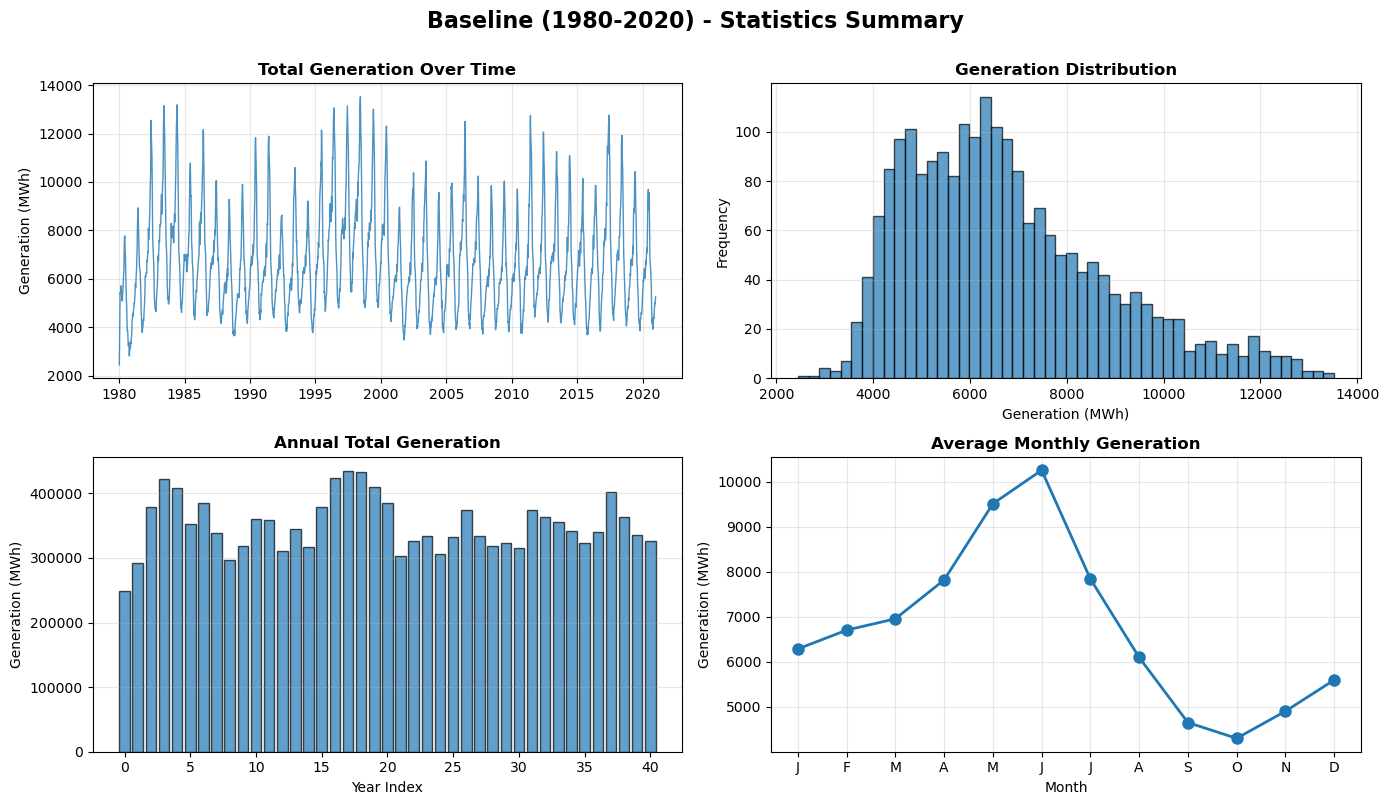

In [6]:
# Plot statistics summary for baseline
plot_statistics_summary(baseline_df, simulation_name='Baseline (1980-2020)')


### 2. Compare multiple climate simulations

In [7]:
# Compare total generation across all future simulations
future_sims = ['ec-earth3', 'miroc6', 'mpi-esm1-2-hr', 'taiesm1']
comparison_df = loader.compare_simulations(simulations=future_sims)

# Show comparison
comparison_df.head()


Loading EC-Earth3 Weekly Generation 2015 - 2060_May29.csv...
  Loaded 2392 weeks of data
  223 facilities
  Date range: 2015-01-05 to 2060-12-27
Loading MIROC6 Weekly Generation 2015 - 2060_May29.csv...
  Loaded 2392 weeks of data
  223 facilities
  Date range: 2015-01-05 to 2060-12-27
Loading MPI-ESM1-2-HR Weekly Generation 2015 - 2060_May29.csv...
  Loaded 2392 weeks of data
  223 facilities
  Date range: 2015-01-05 to 2060-12-27
Loading TaiESM1 Weekly Generation 2015 - 2060_May29.csv...
  Loaded 2392 weeks of data
  223 facilities
  Date range: 2015-01-05 to 2060-12-27
Loading MPI-ESM1-2-HR Weekly Generation 2015 - 2060_May29.csv...
  Loaded 2392 weeks of data
  223 facilities
  Date range: 2015-01-05 to 2060-12-27
Loading TaiESM1 Weekly Generation 2015 - 2060_May29.csv...
  Loaded 2392 weeks of data
  223 facilities
  Date range: 2015-01-05 to 2060-12-27
  Loaded 2392 weeks of data
  223 facilities
  Date range: 2015-01-05 to 2060-12-27


,ec-earth3,miroc6,mpi-esm1-2-hr,taiesm1
date,,,,
2015-01-05,2442.835518,2442.835518,2442.835518,2442.835518
2015-01-12,3466.377574,3466.377574,3466.377574,3466.377574
2015-01-19,4224.965366,4224.965366,4224.965366,4224.965366
2015-01-26,5427.056267,5427.056267,5427.056267,5427.056267
2015-02-02,5396.192493,5396.192493,5396.192493,5396.192493


(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Total Hydropower Generation - Multi-Model Comparison (2015-2060)'}, xlabel='Date', ylabel='Total Generation (MWh)'>)

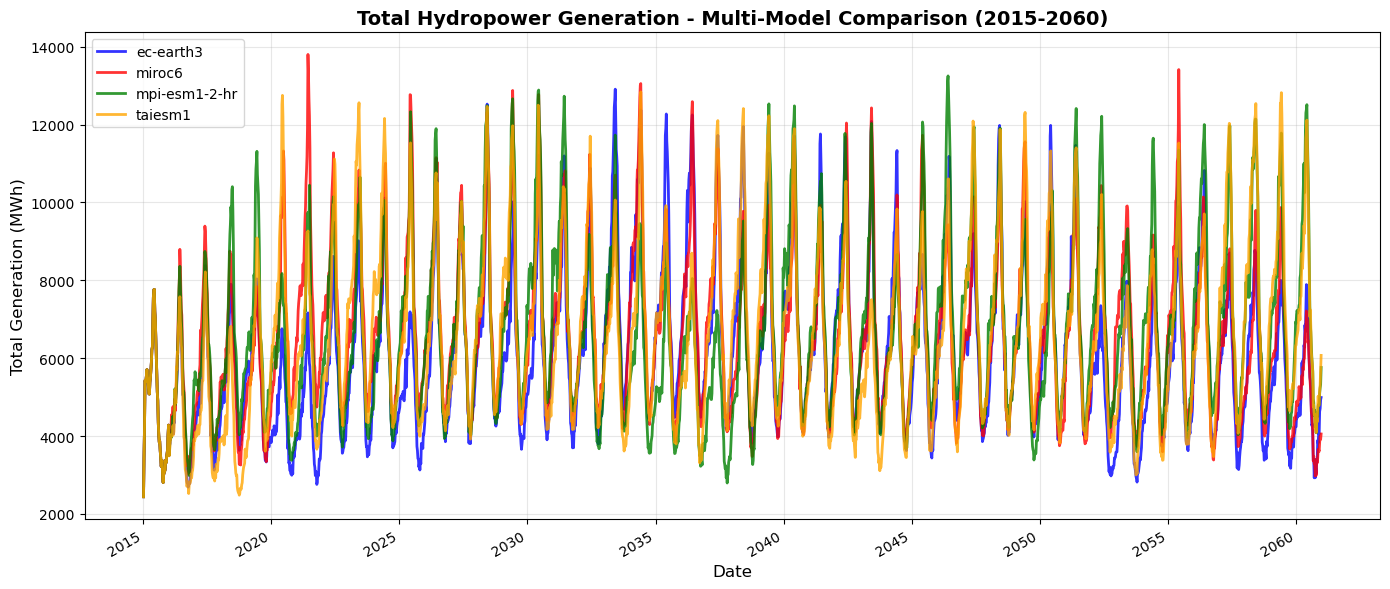

In [8]:
# Plot comparison
plot_comparison(comparison_df, title='Total Hydropower Generation - Multi-Model Comparison (2015-2060)')


In [9]:
# Calculate and display summary statistics
print("Multi-Model Comparison Statistics:")
print("=" * 70)
print("\nMean Generation (MWh):")
print(comparison_df.mean())
print("\nStandard Deviation:")
print(comparison_df.std())
print("\nCorrelation Matrix:")
print(comparison_df.corr().round(3))


Multi-Model Comparison Statistics:

Mean Generation (MWh):
ec-earth3        6131.344749
miroc6           6582.414274
mpi-esm1-2-hr    6653.410415
taiesm1          6523.639320
dtype: float64

Standard Deviation:
ec-earth3        2027.187202
miroc6           1991.920935
mpi-esm1-2-hr    2142.698955
taiesm1          2162.923798
dtype: float64

Correlation Matrix:
               ec-earth3  miroc6  mpi-esm1-2-hr  taiesm1
ec-earth3          1.000   0.852          0.792    0.813
miroc6             0.852   1.000          0.822    0.844
mpi-esm1-2-hr      0.792   0.822          1.000    0.838
taiesm1            0.813   0.844          0.838    1.000


### 3. Analyze specific facilities

In [10]:
# Load facility list to see available facilities
facilities = loader.get_facility_list()
if facilities is not None:
    print("Available Hydropower Facilities:")
    display(facilities.head(10))


Available Hydropower Facilities:


,WEAP_name,SWITCH_name,load_zone_name,gen_tech,capacity_limit_mw,capacity_weight,RoR_or_Reservoir,not_generating_in_WEAP,EIA_plant_id,River,Notes
0,Alamo,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,SWP East Branch,NaN
1,Albeni Falls,Albeni Falls,WA_ID_AVA,Hydro_NonPumped,42.0,1.0,Reservoir,0,851.0,Clark Fork and Pend Oreille,NaN
2,Alcova,Alcova,WY_SE,Hydro_NonPumped,41.4,1.0,RoR,0,6409.0,North Fork Platte River,NaN
3,Alder,Alder,WA_W,Hydro_NonPumped,50.0,1.0,Reservoir,0,3913.0,Nisqually River,NaN
4,All American Hydro,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,All American Canal CA,NaN
5,American Falls,American Falls,ID_E,Hydro_NonPumped,92.4,1.0,Reservoir,0,809.0,Snake River,NaN
6,Anderson Ranch,Anderson Ranch,ID_S_OR_E,Hydro_NonPumped,40.0,1.0,Reservoir,0,6395.0,Boise River,NaN
7,Arrow Lakes CAN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Columbia Headwaters,"Canadian generator, don't have data from EIA"
8,Balch 1,Balch 1,CA_PGE_CEN,Hydro_NonPumped,31.0,1.0,RoR,0,217.0,North Fork Kings River,NaN
9,Balch 2,Balch 2,CA_PGE_CEN,Hydro_NonPumped,97.2,1.0,RoR,0,218.0,North Fork Kings River,NaN


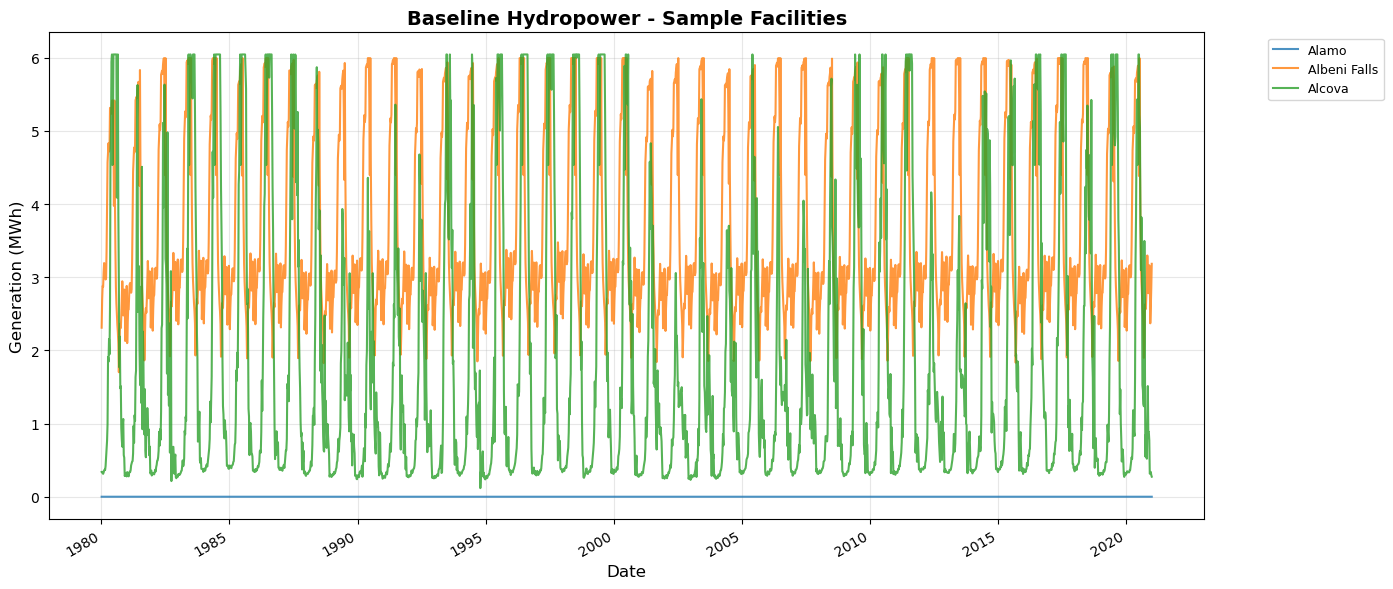

In [11]:
# Example: Compare a specific facility across simulations
# (Replace 'facility_name' with actual column name from your data)
# facility_comparison = loader.compare_simulations(facility_name='Your_Facility_Name_Here')
# plot_comparison(facility_comparison, title='Facility Name - Multi-Model Comparison')

# Or plot specific facilities from baseline data
if len(baseline_df.columns) > 0:
    # Plot first 3 facilities as example
    plot_timeseries(baseline_df, 
                    title='Baseline Hydropower - Sample Facilities',
                    columns=baseline_df.columns[:3].tolist())


### 4. Seasonal analysis

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Baseline - Average Annual Cycle'}, xlabel='Week of Year', ylabel='Generation (MWh)'>)

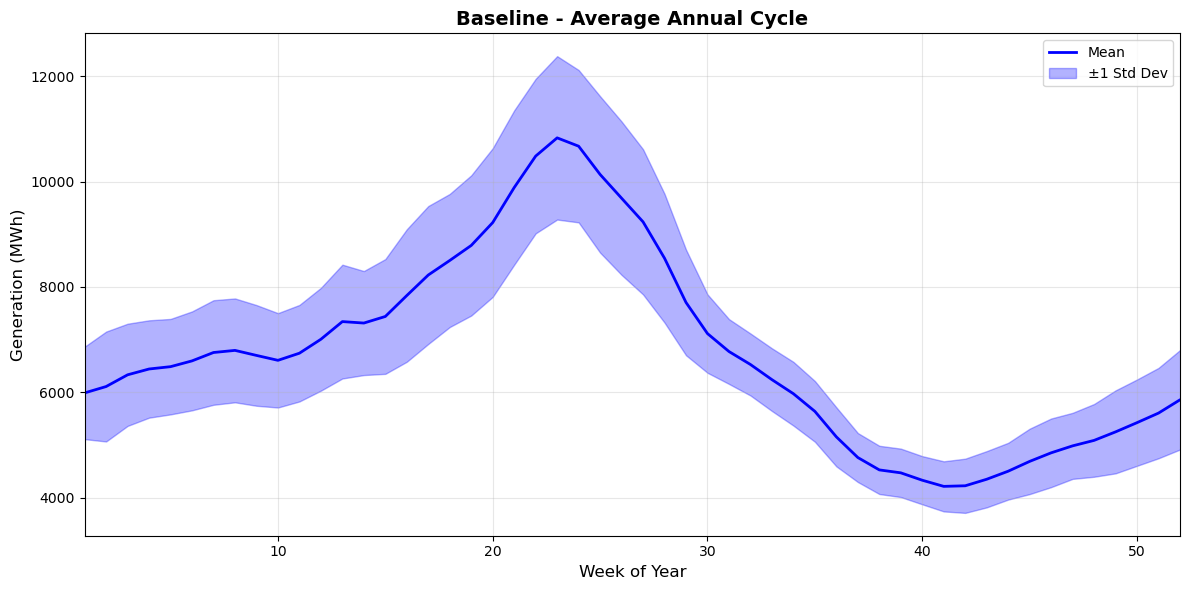

In [12]:
# Plot annual cycle for baseline
plot_annual_cycle(baseline_df, simulation_name='Baseline')


Using cached data for baseline
Using cached data for ec-earth3
Using cached data for miroc6
Using cached data for mpi-esm1-2-hr
Using cached data for taiesm1


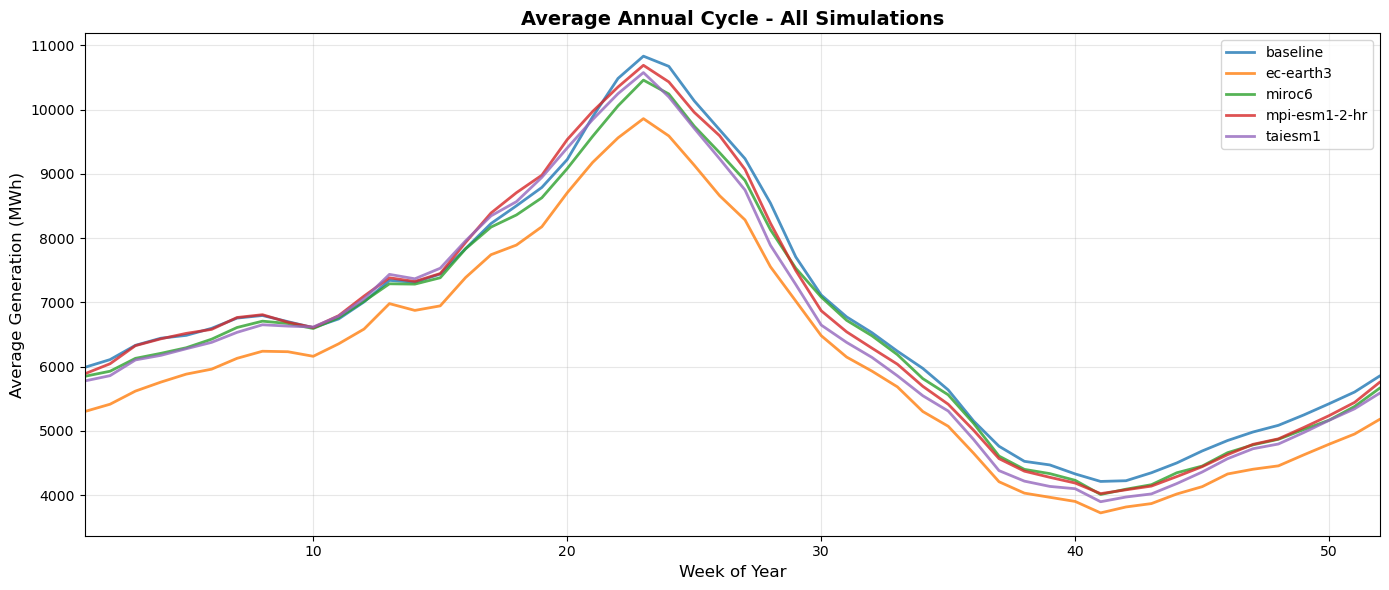

In [13]:
# Compare annual cycles across all simulations
fig, ax = plt.subplots(figsize=(14, 6))

for sim in ['baseline', 'ec-earth3', 'miroc6', 'mpi-esm1-2-hr', 'taiesm1']:
    df = loader.load(sim)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    total_gen = df[numeric_cols].sum(axis=1)
    weekly_avg = total_gen.groupby(total_gen.index.isocalendar().week).mean()
    
    ax.plot(weekly_avg.index, weekly_avg.values, linewidth=2, label=sim, alpha=0.8)

ax.set_title('Average Annual Cycle - All Simulations', fontsize=14, fontweight='bold')
ax.set_xlabel('Week of Year', fontsize=12)
ax.set_ylabel('Average Generation (MWh)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_xlim(1, 52)
plt.tight_layout()


### 5. Export processed data

### 6. Model Change Analysis vs Baseline (2030-2060)

Compare how each climate model simulates changes in hydropower generation relative to the baseline period.

In [14]:
# Calculate baseline average annual cycle (full historical period 1980-2020)
baseline_total = baseline_df.select_dtypes(include=[np.number]).sum(axis=1)
baseline_cycle = baseline_total.groupby(baseline_total.index.isocalendar().week).mean()

# Load and process each climate model for 2030-2060 period
models = ['ec-earth3', 'miroc6', 'mpi-esm1-2-hr', 'taiesm1']
model_cycles = {}
model_data_2030_2060 = {}

for model in models:
    # Load full model data
    df = loader.load(model)
    
    # Trim to 2030-2060
    df_trimmed = df.loc['2030':'2060']
    model_data_2030_2060[model] = df_trimmed
    
    # Calculate total generation and annual cycle
    total_gen = df_trimmed.select_dtypes(include=[np.number]).sum(axis=1)
    model_cycles[model] = total_gen.groupby(total_gen.index.isocalendar().week).mean()
    
    print(f"{model:15s}: {len(df_trimmed):4d} weeks ({df_trimmed.index[0].year}-{df_trimmed.index[-1].year})")

print(f"{'baseline':15s}: {len(baseline_df):4d} weeks (1980-2020)")
print(f"\nBaseline cycle shape: {baseline_cycle.shape}")
print(f"Model cycle shape: {model_cycles['ec-earth3'].shape}")

Using cached data for ec-earth3
ec-earth3      : 1612 weeks (2030-2060)
Using cached data for miroc6
miroc6         : 1612 weeks (2030-2060)
Using cached data for mpi-esm1-2-hr
mpi-esm1-2-hr  : 1612 weeks (2030-2060)
Using cached data for taiesm1
taiesm1        : 1612 weeks (2030-2060)
baseline       : 2132 weeks (1980-2020)

Baseline cycle shape: (53,)
Model cycle shape: (53,)


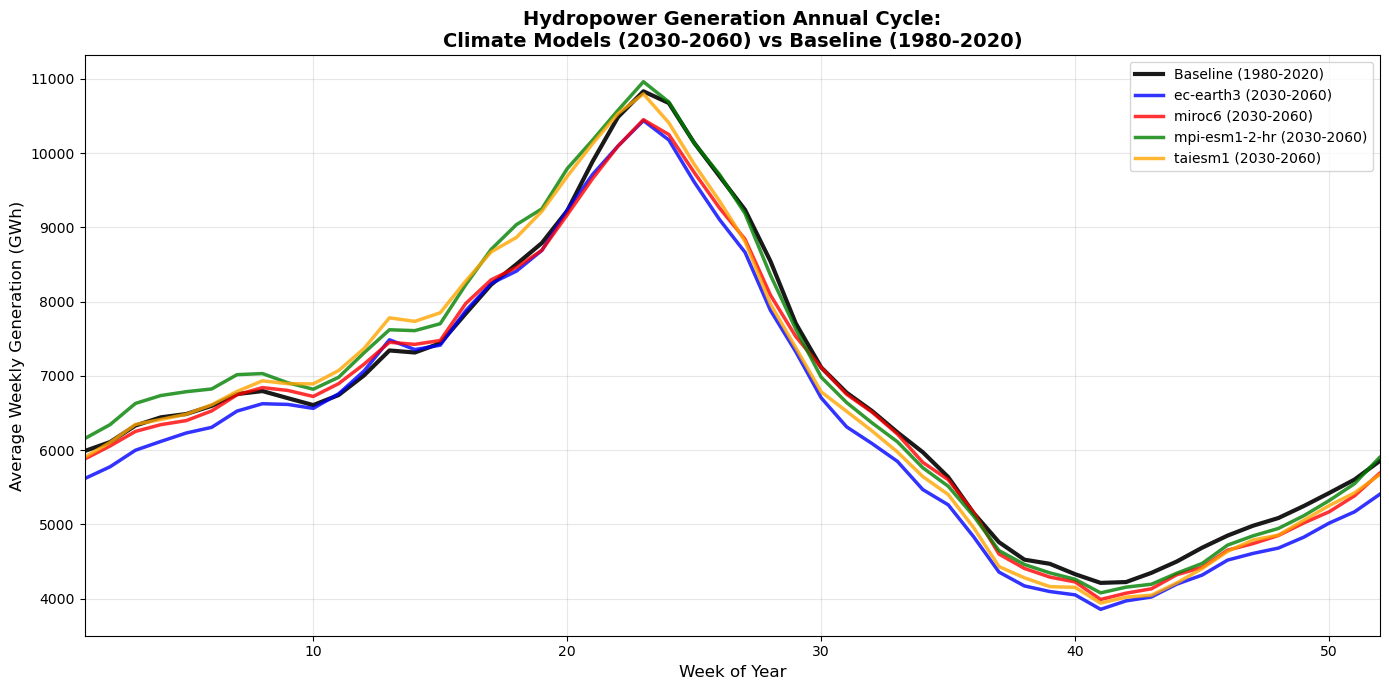

In [15]:
# Plot: Model cycles vs Baseline (2030-2060)
fig, ax = plt.subplots(figsize=(14, 7))

# Plot baseline
ax.plot(baseline_cycle.index, baseline_cycle.values, 
        linewidth=3, label='Baseline (1980-2020)', color='black', linestyle='-', alpha=0.9)

# Plot each model
colors = {'ec-earth3': 'blue', 'miroc6': 'red', 'mpi-esm1-2-hr': 'green', 'taiesm1': 'orange'}
for model in models:
    ax.plot(model_cycles[model].index, model_cycles[model].values,
            linewidth=2.5, label=f'{model} (2030-2060)', color=colors[model], alpha=0.8)

ax.set_title('Hydropower Generation Annual Cycle:\nClimate Models (2030-2060) vs Baseline (1980-2020)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Week of Year', fontsize=12)
ax.set_ylabel('Average Weekly Generation (GWh)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')
ax.set_xlim(1, 52)
plt.tight_layout()
plt.show()

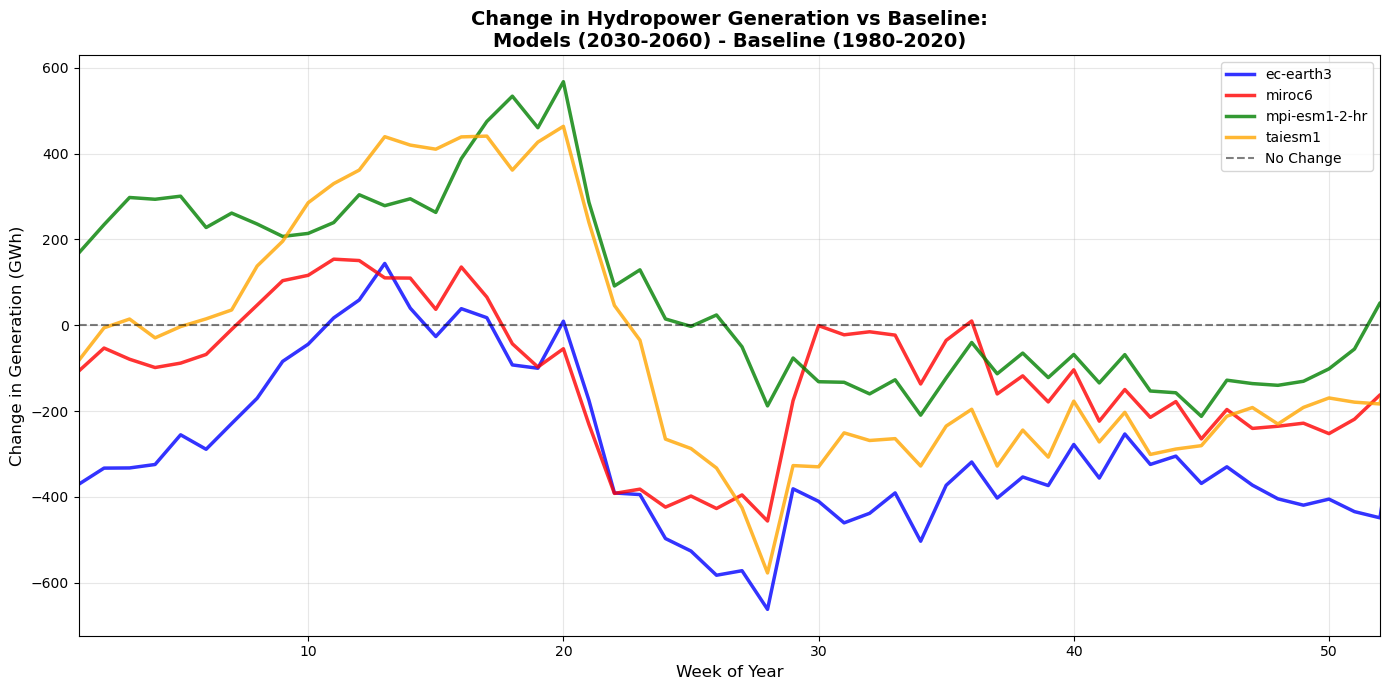

In [16]:
# Calculate and plot absolute change (Model - Baseline) for each week
fig, ax = plt.subplots(figsize=(14, 7))

for model in models:
    # Calculate difference from baseline
    delta = model_cycles[model].values - baseline_cycle.values
    ax.plot(model_cycles[model].index, delta, linewidth=2.5, 
            label=f'{model}', color=colors[model], alpha=0.8)

# Add zero reference line
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='No Change')

ax.set_title('Change in Hydropower Generation vs Baseline:\nModels (2030-2060) - Baseline (1980-2020)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Week of Year', fontsize=12)
ax.set_ylabel('Change in Generation (GWh)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')
ax.set_xlim(1, 52)
plt.tight_layout()
plt.show()

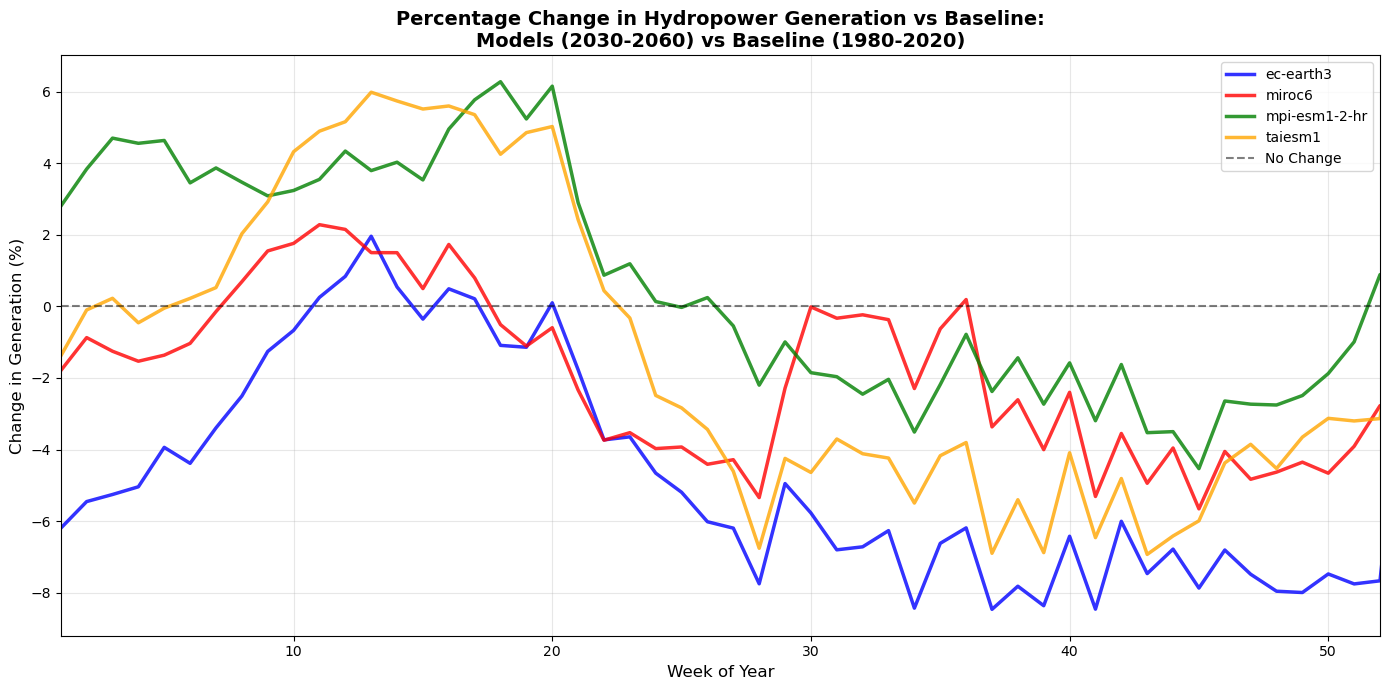

In [17]:
# Calculate and plot percentage change relative to baseline
fig, ax = plt.subplots(figsize=(14, 7))

for model in models:
    # Calculate percentage difference from baseline
    pct_change = ((model_cycles[model].values - baseline_cycle.values) / baseline_cycle.values) * 100
    ax.plot(model_cycles[model].index, pct_change, linewidth=2.5, 
            label=f'{model}', color=colors[model], alpha=0.8)

# Add zero reference line
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='No Change')

ax.set_title('Percentage Change in Hydropower Generation vs Baseline:\nModels (2030-2060) vs Baseline (1980-2020)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Week of Year', fontsize=12)
ax.set_ylabel('Change in Generation (%)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')
ax.set_xlim(1, 52)
plt.tight_layout()
plt.show()

In [18]:
# Summary statistics: Annual mean changes
print("Summary Statistics: Model (2030-2060) vs Baseline (1980-2020)")
print("=" * 80)

baseline_annual_mean = baseline_cycle.mean()
print(f"\nBaseline Annual Mean: {baseline_annual_mean:.2f} GWh/week")
print("\nModel Annual Means (2030-2060):")

results = []
for model in models:
    model_mean = model_cycles[model].mean()
    abs_change = model_mean - baseline_annual_mean
    pct_change = (abs_change / baseline_annual_mean) * 100
    
    results.append({
        'Model': model,
        'Mean (GWh/week)': model_mean,
        'Abs Change (GWh/week)': abs_change,
        'Change (%)': pct_change
    })
    
    print(f"  {model:15s}: {model_mean:8.2f} GWh/week "
          f"(Δ = {abs_change:+7.2f} GWh/week, {pct_change:+6.2f}%)")

# Create summary DataFrame
summary_df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("\nSummary Table:")
display(summary_df.round(2))

Summary Statistics: Model (2030-2060) vs Baseline (1980-2020)

Baseline Annual Mean: 6728.59 GWh/week

Model Annual Means (2030-2060):
  ec-earth3      :  6440.15 GWh/week (Δ = -288.44 GWh/week,  -4.29%)
  miroc6         :  6606.59 GWh/week (Δ = -122.00 GWh/week,  -1.81%)
  mpi-esm1-2-hr  :  6801.84 GWh/week (Δ =  +73.25 GWh/week,  +1.09%)
  taiesm1        :  6675.26 GWh/week (Δ =  -53.33 GWh/week,  -0.79%)


Summary Table:


,Model,Mean (GWh/week),Abs Change (GWh/week),Change (%)
0,ec-earth3,6440.15,-288.44,-4.29
1,miroc6,6606.59,-122.00,-1.81
2,mpi-esm1-2-hr,6801.84,73.25,1.09
3,taiesm1,6675.26,-53.33,-0.79


In [19]:
# Seasonal analysis: Winter (weeks 1-13, 40-52) vs Summer (weeks 14-39)
print("Seasonal Analysis: Model Changes vs Baseline")
print("=" * 80)

winter_weeks = list(range(1, 14)) + list(range(40, 53))
summer_weeks = list(range(14, 40))

baseline_winter = baseline_cycle.loc[baseline_cycle.index.isin(winter_weeks)].mean()
baseline_summer = baseline_cycle.loc[baseline_cycle.index.isin(summer_weeks)].mean()

print(f"\nBaseline:")
print(f"  Winter Mean: {baseline_winter:.2f} GWh/week")
print(f"  Summer Mean: {baseline_summer:.2f} GWh/week")

for model in models:
    model_winter = model_cycles[model].loc[model_cycles[model].index.isin(winter_weeks)].mean()
    model_summer = model_cycles[model].loc[model_cycles[model].index.isin(summer_weeks)].mean()
    
    winter_change = ((model_winter - baseline_winter) / baseline_winter) * 100
    summer_change = ((model_summer - baseline_summer) / baseline_summer) * 100
    
    print(f"\n{model}:")
    print(f"  Winter Mean: {model_winter:.2f} GWh/week ({winter_change:+.2f}% vs baseline)")
    print(f"  Summer Mean: {model_summer:.2f} GWh/week ({summer_change:+.2f}% vs baseline)")

Seasonal Analysis: Model Changes vs Baseline

Baseline:
  Winter Mean: 5740.35 GWh/week
  Summer Mean: 7757.96 GWh/week

ec-earth3:
  Winter Mean: 5474.33 GWh/week (-4.63% vs baseline)
  Summer Mean: 7437.81 GWh/week (-4.13% vs baseline)

miroc6:
  Winter Mean: 5644.45 GWh/week (-1.67% vs baseline)
  Summer Mean: 7611.36 GWh/week (-1.89% vs baseline)

mpi-esm1-2-hr:
  Winter Mean: 5810.63 GWh/week (+1.22% vs baseline)
  Summer Mean: 7834.33 GWh/week (+0.98% vs baseline)

taiesm1:
  Winter Mean: 5694.67 GWh/week (-0.80% vs baseline)
  Summer Mean: 7690.38 GWh/week (-0.87% vs baseline)


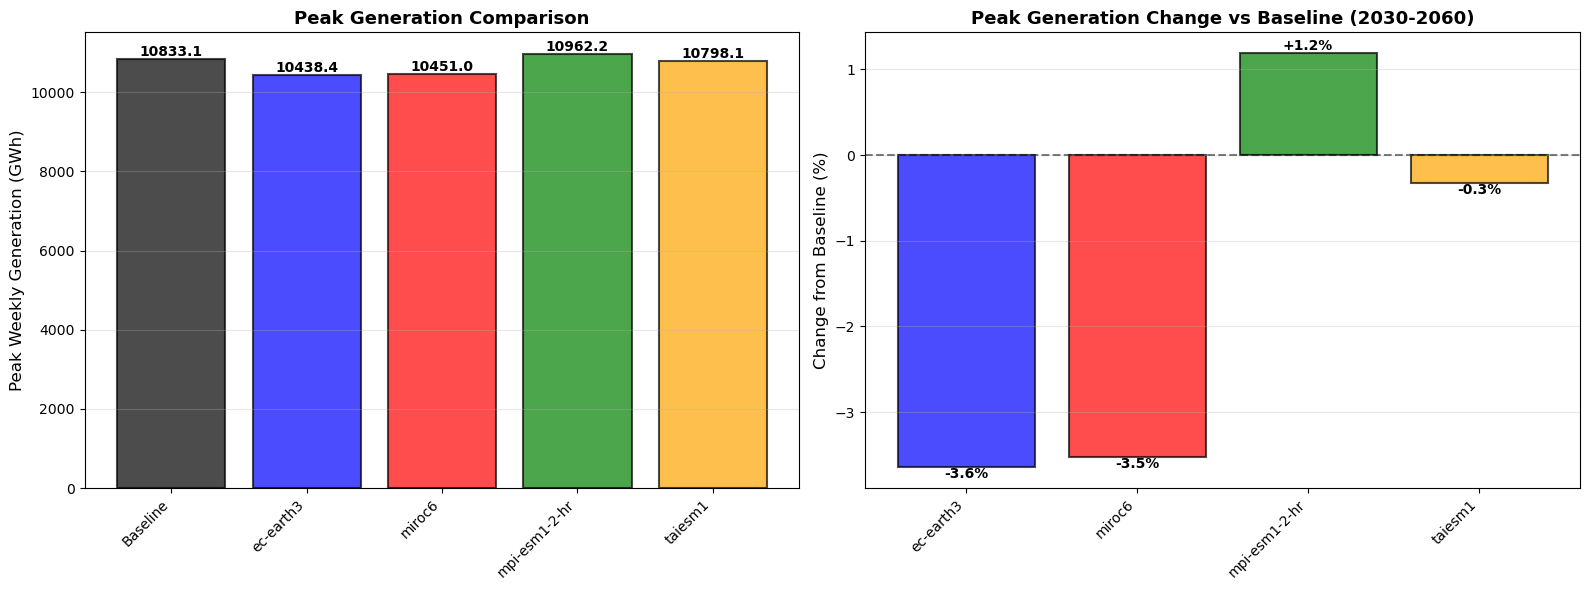


Peak Generation Summary:
Simulation         Peak (GWh/week)   Week #   Change (%)
--------------------------------------------------------------------------------
Baseline                  10833.14       23            -
ec-earth3                 10438.36       23       -3.64%
miroc6                    10450.98       23       -3.53%
mpi-esm1-2-hr             10962.23       23        1.19%
taiesm1                   10798.06       23       -0.32%


In [21]:
# Peak generation comparison: Baseline vs Models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Peak generation values
baseline_peak = baseline_cycle.max()
baseline_peak_week = baseline_cycle.idxmax()

peak_data = {
    'Simulation': ['Baseline'] + models,
    'Peak Generation (GWh/week)': [baseline_peak],
    'Peak Week': [baseline_peak_week]
}

for model in models:
    model_peak = model_cycles[model].max()
    model_peak_week = model_cycles[model].idxmax()
    peak_data['Peak Generation (GWh/week)'].append(model_peak)
    peak_data['Peak Week'].append(model_peak_week)

# Bar chart of peak values
bar_colors = ['black'] + [colors[m] for m in models]
ax1.bar(range(len(peak_data['Simulation'])), 
        peak_data['Peak Generation (GWh/week)'],
        color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(peak_data['Simulation'])))
ax1.set_xticklabels(peak_data['Simulation'], rotation=45, ha='right')
ax1.set_ylabel('Peak Weekly Generation (GWh)', fontsize=12)
ax1.set_title('Peak Generation Comparison', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, val in enumerate(peak_data['Peak Generation (GWh/week)']):
    ax1.text(i, val, f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right panel: Change in peak from baseline
peak_changes = [(p - baseline_peak) / baseline_peak * 100 
                for p in peak_data['Peak Generation (GWh/week)'][1:]]

ax2.bar(range(len(models)), peak_changes,
        color=[colors[m] for m in models], alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('Change from Baseline (%)', fontsize=12)
ax2.set_title('Peak Generation Change vs Baseline (2030-2060)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, val in enumerate(peak_changes):
    y_pos = val if val > 0 else val
    va = 'bottom' if val > 0 else 'top'
    ax2.text(i, y_pos, f'{val:+.1f}%', ha='center', va=va, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\nPeak Generation Summary:")
print("=" * 80)
print(f"{'Simulation':<15s} {'Peak (GWh/week)':>18s} {'Week #':>8s} {'Change (%)':>12s}")
print("-" * 80)
print(f"{'Baseline':<15s} {baseline_peak:>18.2f} {baseline_peak_week:>8d} {'-':>12s}")
for i, model in enumerate(models):
    peak_val = peak_data['Peak Generation (GWh/week)'][i+1]
    peak_wk = peak_data['Peak Week'][i+1]
    change = peak_changes[i]
    print(f"{model:<15s} {peak_val:>18.2f} {peak_wk:>8d} {change:>11.2f}%")

In [20]:
# Example: Save comparison data to CSV
# comparison_df.to_csv('../data/hydro/processed/multi_model_comparison.csv')

print("Export examples (uncomment to use):")
print("  - Save to CSV: comparison_df.to_csv('output.csv')")


Export examples (uncomment to use):
  - Save to CSV: comparison_df.to_csv('output.csv')
